In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#import data
train_df = pd.read_csv('data/Recvidism_extra_feat_train.csv')
test_df = pd.read_csv('data/Recvidism_extra_feat_test.csv')


In [2]:
# Make Recidivism_Within_3years the last column in train data
cols = [col for col in train_df.columns if col != 'Recidivism_Within_3years']
cols.append('Recidivism_Within_3years')
train_df = train_df[cols]

# Make Recidivism_Within_3years the last column in test data
cols = [col for col in test_df.columns if col != 'Recidivism_Within_3years']
cols.append('Recidivism_Within_3years')
test_df = test_df[cols]

### MLP

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
class DataFrameDataset(Dataset):
    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): source data
        """
        # Assuming the last column is the label
        self.features = dataframe.iloc[:, :-1].values
        self.labels = dataframe.iloc[:, -1].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Convert features and labels to tensors
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return features, label


In [5]:
#Convert pd dataframe to torch dataset
train_dataset = DataFrameDataset(train_df)
test_dataset = DataFrameDataset(train_df)

# use 15% of training data for validation
train_set_size = int(len(train_dataset) * 0.85)
valid_set_size = len(train_dataset) - train_set_size
train_set, valid_set = torch.utils.data.random_split(train_dataset, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(42))

# DataLoaders
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
total_train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [10]:
train_df.shape

(18028, 66)

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Create fully connected layers (nn.Linear)
        ### START CODE ###
        self.fc1 = nn.Linear(65, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        ### END CODE ###

    def forward(self, x):
        ### START CODE ###
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ### END CODE ###
        return x


In [12]:
model = MLP()
# Create the optimizer
### START CODE ###
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
### END CODE ###

In [13]:
# Create the loss function instance
criterion = torch.nn.BCEWithLogitsLoss()

def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    total_num = 0
    for data, target in tqdm(loader):
        out = model(data)
        # Calculate loss based on model output and target
        ### START CODE ###
        target = target.unsqueeze(1) 
        loss = criterion(out, target.float())
        ### END CODE ###

        # Use the optimizer to perform backpropagation
        ### START CODE ###
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ### END CODE ###

        batch_size = len(target)
        total_loss += loss.item() * batch_size
        total_num += batch_size
    avg_loss = total_loss / total_num
    return avg_loss

@torch.no_grad()
def eval(model, loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_num = 0
    for data, target in tqdm(loader):
        out = model(data)
        # Calculate loss based on model output and target
        ### START CODE ###
        target = target.unsqueeze(1) 
        loss = criterion(out, target.float())
        ### END CODE ###

        # Get model's prediction
        ### START CODE ###
        pred = torch.sigmoid(out) >= 0.5
        ### END CODE ###

        # Count number of correct predictions
        ### START CODE ###
        correct = (pred.float() == target.float()).sum().item()
        ### END CODE ###

        total_correct += correct
        batch_size = len(target)
        total_loss += loss.item() * batch_size
        total_num += batch_size
    avg_loss = total_loss / total_num
    acc = total_correct / total_num
    return avg_loss, acc


In [14]:
epochs = 15
for e in range(1, epochs + 1):
    train_loss = train(model, train_loader, optimizer)
    val_loss, val_acc = eval(model, val_loader)
    print(f"Epoch: {e} Train Loss: {train_loss} Val Loss: {val_loss} Val Acc: {val_acc}")

100%|██████████| 11/11 [00:00<00:00, 423.52it/s]


Epoch: 1 Train Loss: 0.6519275237559681 Val Loss: 0.6330206875660063 Val Acc: 0.6473197781885397


100%|██████████| 11/11 [00:00<00:00, 440.02it/s]


Epoch: 2 Train Loss: 0.6096134538253123 Val Loss: 0.5877523661761539 Val Acc: 0.6935304990757856


100%|██████████| 11/11 [00:00<00:00, 458.51it/s]


Epoch: 3 Train Loss: 0.5785488636011493 Val Loss: 0.5678457368764331 Val Acc: 0.7042513863216266


100%|██████████| 11/11 [00:00<00:00, 457.88it/s]


Epoch: 4 Train Loss: 0.5675225447077341 Val Loss: 0.5633014048974747 Val Acc: 0.7083179297597042


100%|██████████| 11/11 [00:00<00:00, 467.89it/s]


Epoch: 5 Train Loss: 0.5617053592118693 Val Loss: 0.5575497790096868 Val Acc: 0.7146025878003697


100%|██████████| 11/11 [00:00<00:00, 478.29it/s]


Epoch: 6 Train Loss: 0.5572778637614751 Val Loss: 0.5554889073653935 Val Acc: 0.7205175600739372


100%|██████████| 11/11 [00:00<00:00, 478.02it/s]


Epoch: 7 Train Loss: 0.5548452000576592 Val Loss: 0.5635694508631878 Val Acc: 0.7097966728280961


100%|██████████| 11/11 [00:00<00:00, 458.52it/s]


Epoch: 8 Train Loss: 0.554012190896522 Val Loss: 0.5513120639346223 Val Acc: 0.7234750462107209


100%|██████████| 11/11 [00:00<00:00, 448.38it/s]


Epoch: 9 Train Loss: 0.5480013782008856 Val Loss: 0.5500406096250425 Val Acc: 0.7223659889094269


100%|██████████| 11/11 [00:00<00:00, 455.82it/s]


Epoch: 10 Train Loss: 0.5489382019306236 Val Loss: 0.5563242059097713 Val Acc: 0.7131238447319779


100%|██████████| 11/11 [00:00<00:00, 439.70it/s]


Epoch: 11 Train Loss: 0.5443615995059162 Val Loss: 0.5484275269420222 Val Acc: 0.721996303142329


100%|██████████| 11/11 [00:00<00:00, 459.45it/s]


Epoch: 12 Train Loss: 0.5453707078476764 Val Loss: 0.5506391235728801 Val Acc: 0.7146025878003697


100%|██████████| 11/11 [00:00<00:00, 466.01it/s]


Epoch: 13 Train Loss: 0.5434609696415879 Val Loss: 0.54656017106474 Val Acc: 0.7245841035120147


100%|██████████| 11/11 [00:00<00:00, 440.00it/s]


Epoch: 14 Train Loss: 0.5431372470113679 Val Loss: 0.5468023102076349 Val Acc: 0.7238447319778188


100%|██████████| 11/11 [00:00<00:00, 439.80it/s]

Epoch: 15 Train Loss: 0.5396521595045161 Val Loss: 0.5469822861350618 Val Acc: 0.7223659889094269


In [15]:
@torch.no_grad()
def test_accuracy(model, loader):
    model.eval()
    total_correct = 0
    total_num = 0
    all_preds = []
    all_targets = []
    all_probs = []  # To store probability estimates

    for data, target in loader:
        out = model(data)
        pred = torch.sigmoid(out) >= 0.5
        correct = (pred.float() == target.unsqueeze(1).float()).sum().item()

        total_correct += correct
        total_num += len(target)

        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_probs.extend(torch.sigmoid(out).cpu().numpy())  # Store probability estimates

    acc = total_correct / total_num
    return acc, all_preds, all_targets, all_probs  # Return probability estimates

test_acc, all_preds, all_targets, all_probs = test_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 72.98%


In [16]:
@torch.no_grad()
def test_roc_auc(model, loader):
    model.eval()
    all_preds = []
    all_targets = []

    for data, target in loader:
        out = model(data)
        pred = torch.sigmoid(out)
        
        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    roc_auc = roc_auc_score(all_targets, all_preds)
    return roc_auc

In [17]:
from sklearn.metrics import brier_score_loss

roc_auc = test_roc_auc(model, test_loader)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

# Calculate the Brier Score using probability estimates
test_acc, _, _, all_probs = test_accuracy(model, test_loader)
brier_score = brier_score_loss(all_targets, all_probs)
print(f"Brier Score on Test Set: {brier_score:.4f}")

ROC AUC Score on Test Set: 0.7980
Brier Score on Test Set: 0.1802


In [18]:
epochs = 15
for e in range(1, epochs + 1):
    train_loss = train(model, total_train_loader, optimizer)  # Use total_train_loader
    val_loss, val_acc = eval(model, val_loader)
    print(f"Epoch: {e} Train Loss: {train_loss} Val Loss: {val_loss} Val Acc: {val_acc}")

# After training, evaluate on the test set
test_acc, all_preds, all_targets, all_probs = test_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


100%|██████████| 11/11 [00:00<00:00, 467.80it/s]


Epoch: 1 Train Loss: 0.5417081129003423 Val Loss: 0.5501741502069061 Val Acc: 0.7245841035120147


100%|██████████| 11/11 [00:00<00:00, 458.16it/s]


Epoch: 2 Train Loss: 0.5382952702423673 Val Loss: 0.5392368747434422 Val Acc: 0.7279112754158965


100%|██████████| 11/11 [00:00<00:00, 458.37it/s]


Epoch: 3 Train Loss: 0.5373771964035728 Val Loss: 0.5400824632970771 Val Acc: 0.7293900184842883


100%|██████████| 11/11 [00:00<00:00, 423.64it/s]


Epoch: 4 Train Loss: 0.5366878225715033 Val Loss: 0.537011939606693 Val Acc: 0.734195933456562


100%|██████████| 11/11 [00:00<00:00, 458.35it/s]


Epoch: 5 Train Loss: 0.5335337206215454 Val Loss: 0.5362655999039105 Val Acc: 0.7353049907578558


100%|██████████| 11/11 [00:00<00:00, 468.17it/s]


Epoch: 6 Train Loss: 0.5344425947604805 Val Loss: 0.5366468432650328 Val Acc: 0.7364140480591497


100%|██████████| 11/11 [00:00<00:00, 458.59it/s]


Epoch: 7 Train Loss: 0.5325965487642248 Val Loss: 0.5317153333736215 Val Acc: 0.7323475046210721


100%|██████████| 11/11 [00:00<00:00, 458.34it/s]


Epoch: 8 Train Loss: 0.5311606537351488 Val Loss: 0.5338781365625519 Val Acc: 0.7375231053604436


100%|██████████| 11/11 [00:00<00:00, 458.49it/s]


Epoch: 9 Train Loss: 0.5290004491991179 Val Loss: 0.5310395904036855 Val Acc: 0.7371534195933457


100%|██████████| 11/11 [00:00<00:00, 467.40it/s]


Epoch: 10 Train Loss: 0.5283224468276695 Val Loss: 0.5360511976557606 Val Acc: 0.7323475046210721


100%|██████████| 11/11 [00:00<00:00, 462.39it/s]


Epoch: 11 Train Loss: 0.5284542575733133 Val Loss: 0.5300165860137305 Val Acc: 0.7390018484288355


100%|██████████| 11/11 [00:00<00:00, 478.29it/s]


Epoch: 12 Train Loss: 0.5265430925768972 Val Loss: 0.528125796741126 Val Acc: 0.7404805914972273


100%|██████████| 11/11 [00:00<00:00, 407.95it/s]


Epoch: 13 Train Loss: 0.5266877974589965 Val Loss: 0.526294255124443 Val Acc: 0.7397412199630314


100%|██████████| 11/11 [00:00<00:00, 459.81it/s]


Epoch: 14 Train Loss: 0.5257044635565974 Val Loss: 0.5288630439922241 Val Acc: 0.7345656192236599


100%|██████████| 11/11 [00:00<00:00, 440.18it/s]


Epoch: 15 Train Loss: 0.524828640775086 Val Loss: 0.5228990286643757 Val Acc: 0.743438077634011
Test Accuracy: 74.16%


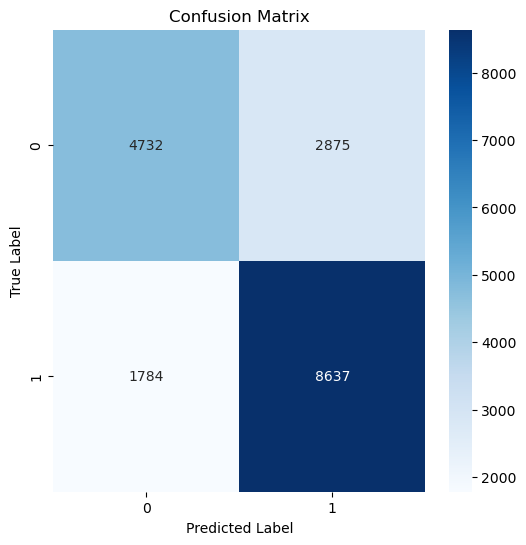

In [19]:
# Calculate the confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [20]:
@torch.no_grad()
def test_roc_auc(model, loader):
    model.eval()
    all_preds = []
    all_targets = []

    for data, target in loader:
        out = model(data)
        pred = torch.sigmoid(out)
        
        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    roc_auc = roc_auc_score(all_targets, all_preds)
    return roc_auc

roc_auc = test_roc_auc(model, test_loader)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

ROC AUC Score on Test Set: 0.8126
